In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
from collections import Counter
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

from random import randint
from multiprocessing import Pool
import threading
from multiprocessing import cpu_count
from functools import partial

import warnings
warnings.filterwarnings("ignore")

Importing Data

In [2]:
df = pd.read_csv("train.csv")
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


Initial Dataset Overview

In [3]:
df.shape #Get the shape of the data

(100000, 28)

In [4]:
df.describe() #Get descriptive statistics of the dataset

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


In [5]:
df.drop_duplicates(inplace=True) #Drop any duplicate rows if present

In [6]:
df.shape #Get the shape of the dataset again to see if any duplicates were removed, in this case there weren't any duplicates

(100000, 28)

In [7]:
df.info() #Get the index dtype and columns, non-null values and memory usage info of the dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

Target Variable:

In [8]:
df['Credit_Score'].value_counts() #Count the unique values in the target variable

Standard    53174
Poor        28998
Good        17828
Name: Credit_Score, dtype: int64

In [9]:
label_encoder = LabelEncoder().fit(df['Credit_Score']) #Create a label encoder object and fitting it to the Credit_Score column in the dataframe.
df['Credit_Score'] = label_encoder.transform(df['Credit_Score']) #Transform the Credit_Score column in the dataframe using the label encoder object
df['Credit_Score'].value_counts() #Count the number of unique values in the Credit_Score column

2    53174
1    28998
0    17828
Name: Credit_Score, dtype: int64

In [10]:
'''Dropping the columns 'Name','SSN','Customer_ID' because these are irrelevant to the prediction'''
df.drop(columns = ['Name','SSN','Customer_ID','Credit_Mix'], axis = 1, inplace = True)

In [11]:
df['ID'] = df.ID.apply(lambda a: int(a, 16)) #Convert the ID stored in hexadecimal point to decimal
df['ID']

0          5634
1          5635
2          5636
3          5637
4          5638
          ...  
99995    155625
99996    155626
99997    155627
99998    155628
99999    155629
Name: ID, Length: 100000, dtype: int64

In [12]:
def getNum(num):
    '''
    This function takes in a string and returns the numeric characters from the string as an integer.

    Parameters:
    num (string): the string to be parsed

    Returns:
    int: the numeric characters from the string
    '''
    toReturn = '' #Create an empty string
    for character in num: #Loop through the characters
        if character.isnumeric(): #If the character is numeric
            toReturn = toReturn + character #Add it to the created string
    return(int(toReturn)) #Return numeric data

df.Num_of_Loan = df.Num_of_Loan.apply(getNum) #Apply the getNum function to the Num_of_Loan column

In [13]:
df.dtypes #Check the data types of the dataframe column

ID                            int64
Month                        object
Age                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                   int64
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                  int64
dtype: object

Here the features 'Age', 'Annual_Income', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly' and  'Monthly_Balance' are supposed to be numerical values but they conain some strigs that need to removed

In [14]:
'''Get only the numberical values from the columns that are supposed to have numerical values'''
float_columns = ['Age', 'Annual_Income', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance'] #Defining the columns that
#should be float64

for column in float_columns: #Iterate over float_columns
    df[column] = df[column].apply(lambda a: re.sub('[^\d\.]', '', str(a))) #Remove any non-numerical values
    df[column] = df[column].replace({'':np.NaN}) #Replace any empty strings with nan values
    df[column] = df[column].astype('float64') #Convert the datatype of the column to 'float64'

In [15]:
object_columns = list(df.dtypes[df.dtypes == "object"].index.values) #Finds the columns that have an object data type and put them in a list
for column in object_columns: #Iterate over the list object_columns
    print(column, df[column].unique()) #Print the unique values of each categorical variable with the column name
    print() #Print an empty line
'''This allows us to see if there are some wrong entries in the categorical variables'''

Month ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']

Occupation ['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect']

Type_of_Loan ['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan'
 'Credit-Builder Loan' 'Auto Loan, Auto Loan, and Not Specified' ...
 'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan'
 'Payday Loan, Student Loan, Mortgage Loan, and Not Specified'
 'Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan']

Credit_History_Age ['22 Years and 1 Months' nan '22 Years and 3 Months'
 '22 Years and 4 Months' '22 Years and 5 Months' '22 Years and 6 Months'
 '22 Years and 7 Months' '26 Years and 7 Months' '26 Years and 8 Months'
 '26 Years and 9 Months' '26 Years and 10 Months' '26 Years and 11 Months'
 '27 Years and 0 Months' '27 Years and 1 Months' '27 Years and 2 Months'
 '17 Years

'This allows us to see if there are some wrong entries in the categorical variables'

In [16]:
#Replacing '_______' in 'Credit_Mix' with something easier to understand
df['Occupation'] = df.Occupation.replace('_______','N/A')
df['Occupation'].unique()

array(['Scientist', 'N/A', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

In [17]:
#Replacing 'NM' in 'Payment_of_Min_Amount' with something easier to understand
df['Payment_of_Min_Amount'] = df.Payment_of_Min_Amount.replace('NM','N/A')
df['Payment_of_Min_Amount'].unique()

array(['No', 'N/A', 'Yes'], dtype=object)

In [18]:
#Replacing '!@9#%8' in 'Payment_Behaviour' with something easier to understand
df['Payment_Behaviour'] = df.Payment_Behaviour.replace('!@9#%8', 'N/A')
df['Payment_Behaviour'].unique()

array(['High_spent_Small_value_payments',
       'Low_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Small_value_payments',
       'High_spent_Medium_value_payments', 'N/A',
       'High_spent_Large_value_payments'], dtype=object)

In [19]:
df['Credit_History_Age'].head()

0    22 Years and 1 Months
1                      NaN
2    22 Years and 3 Months
3    22 Years and 4 Months
4    22 Years and 5 Months
Name: Credit_History_Age, dtype: object

Using only years from Credit_History_Age which originally contains years and months

In [20]:
'''Changing the values in the Credit_History_Age featute to contain only years instead of years and months so that it can be converted to numerical column'''
creditAge = df['Credit_History_Age'].str.extract('(\d+)', expand=False) #Extract the digits from the string in the Credit_History_Age column and create creditAge list.
df['Credit_History_Age'] = creditAge #Replace the column 'Credit_History_Age' with the extracted digits
df['Credit_History_Age'] = df['Credit_History_Age'].astype('float64') #Change the data type of the column to float64
df['Credit_History_Age']

0        22.0
1         NaN
2        22.0
3        22.0
4        22.0
         ... 
99995    31.0
99996    31.0
99997    31.0
99998    31.0
99999    31.0
Name: Credit_History_Age, Length: 100000, dtype: float64

In [21]:
numeric_columns = list(df.dtypes[df.dtypes == "float64"].index.values) + list(df.dtypes[df.dtypes == "int64"].index.values)
numeric_columns.remove('Credit_Score') #Since Credit_Score is not a numerical feature but has been converted to numerical values using LabelEncoder

Removing Negative Values

In [22]:
num = df.select_dtypes(include=[np.number]) #Select the numeric columns
(num < 0).sum() #Check if any columns has negative values

ID                            0
Age                           0
Annual_Income                 0
Monthly_Inhand_Salary         0
Num_Bank_Accounts            21
Num_Credit_Card               0
Interest_Rate                 0
Num_of_Loan                   0
Delay_from_due_date         591
Num_of_Delayed_Payment        0
Changed_Credit_Limit          0
Num_Credit_Inquiries          0
Outstanding_Debt              0
Credit_Utilization_Ratio      0
Credit_History_Age            0
Total_EMI_per_month           0
Amount_invested_monthly       0
Monthly_Balance               0
Credit_Score                  0
dtype: int64

In [23]:
def remove_negative_values(df):
    '''
    Removes negative values from the columns of a given dataframe.

            Parameters:
                    df (DataFrame): A Pandas DataFrame 

            Returns:
                    df (DataFrame): DataFrame with negative values replaced by absolute values
    '''
    for column in df: #Loop through each column in the dataframe 'df'
        if df[column].dtype == 'int64' or df[column].dtype == 'float64': #Check if the type of data in the column is an integer or a float
            df[column] = df[column].mask(df[column] < 0, abs(df[column])) #Replace any negative values with the absolute value of the same number
    return df #Return the modified dataframe

remove_negative_values(df)

,ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,January,23.0,Scientist,19114.12,1824.843333,3,4,3,4,...,4.0,809.98,26.822620,22.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,0
1,5635,February,23.0,Scientist,19114.12,NaN,3,4,3,4,...,4.0,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,0
2,5636,March,500.0,Scientist,19114.12,NaN,3,4,3,4,...,4.0,809.98,28.609352,22.0,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,0
3,5637,April,23.0,Scientist,19114.12,NaN,3,4,3,4,...,4.0,809.98,31.377862,22.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,0
4,5638,May,23.0,Scientist,19114.12,1824.843333,3,4,3,4,...,4.0,809.98,24.797347,22.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,155625,April,25.0,Mechanic,39628.99,3359.415833,4,6,7,2,...,3.0,502.38,34.663572,31.0,No,35.104023,60.971333,High_spent_Large_value_payments,479.866228,1
99996,155626,May,25.0,Mechanic,39628.99,3359.415833,4,6,7,2,...,3.0,502.38,40.565631,31.0,No,35.104023,54.185950,High_spent_Medium_value_payments,496.651610,1
99997,155627,June,25.0,Mechanic,39628.99,3359.415833,4,6,5729,2,...,3.0,502.38,41.255522,31.0,No,35.104023,24.028477,High_spent_Large_value_payments,516.809083,1
99998,155628,July,25.0,Mechanic,39628.99,3359.415833,4,6,7,2,...,3.0,502.38,33.638208,31.0,No,35.104023,251.672582,Low_spent_Large_value_payments,319.164979,2


<IPython.core.display.Javascript object>

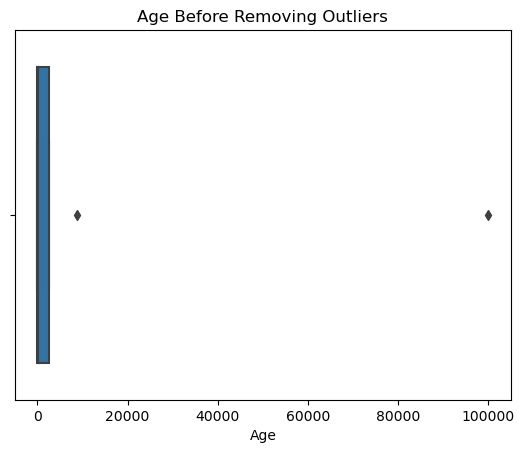

<IPython.core.display.Javascript object>

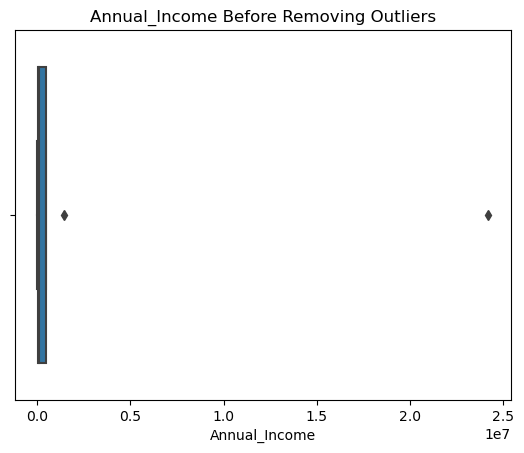

<IPython.core.display.Javascript object>

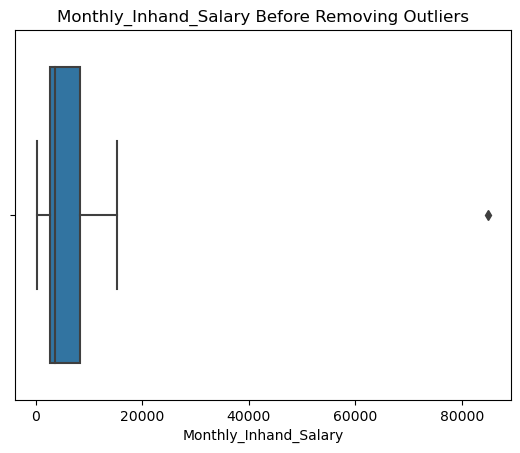

<IPython.core.display.Javascript object>

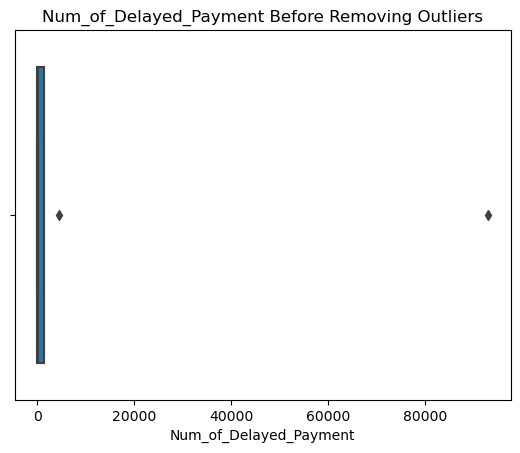

<IPython.core.display.Javascript object>

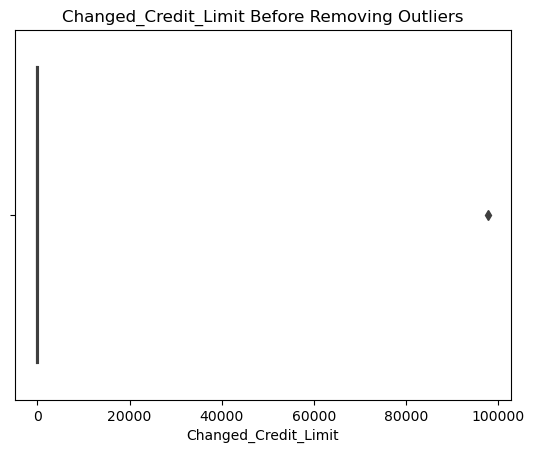

<IPython.core.display.Javascript object>

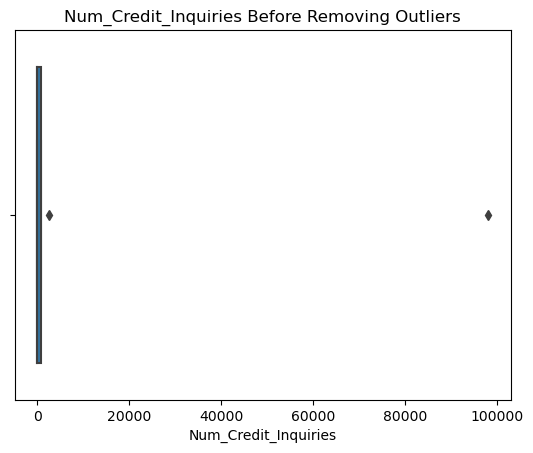

<IPython.core.display.Javascript object>

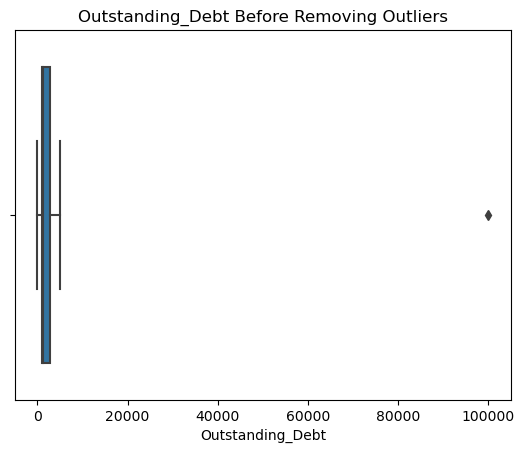

<IPython.core.display.Javascript object>

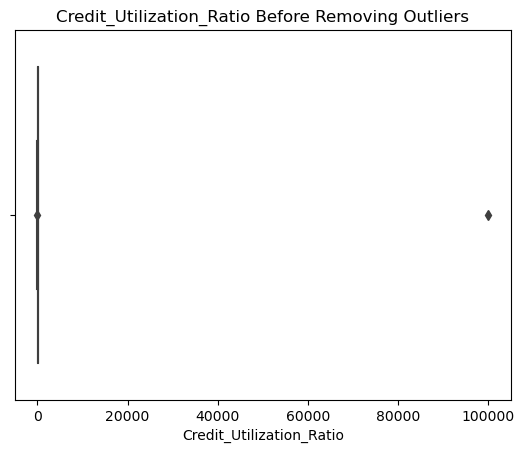

<IPython.core.display.Javascript object>

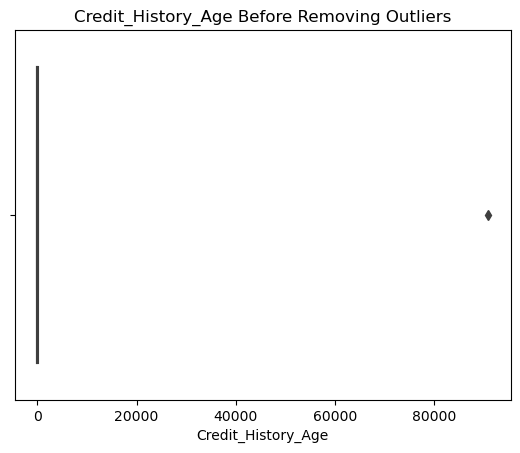

<IPython.core.display.Javascript object>

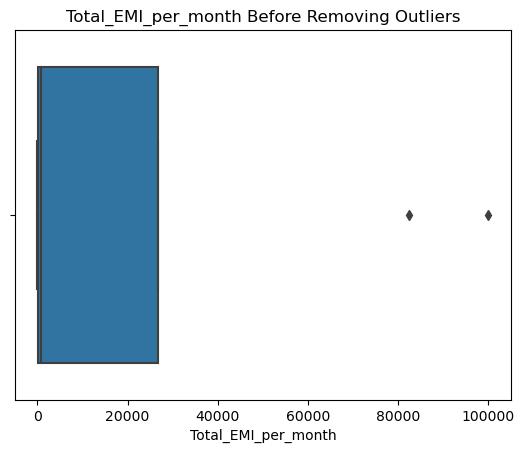

<IPython.core.display.Javascript object>

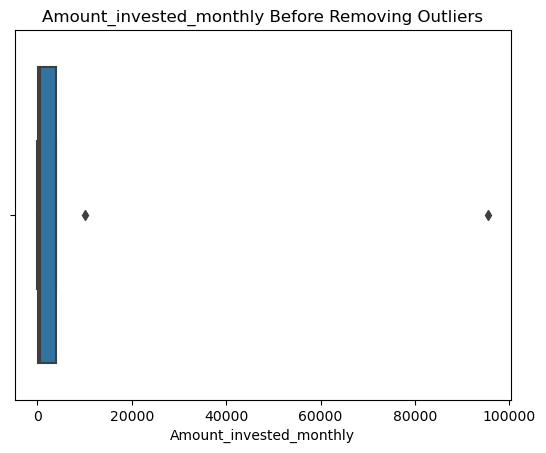

<IPython.core.display.Javascript object>

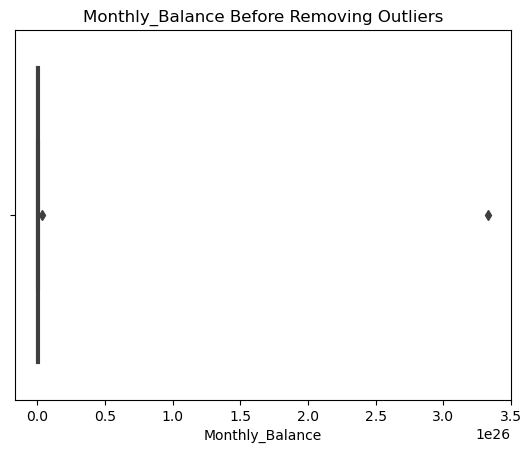

<IPython.core.display.Javascript object>

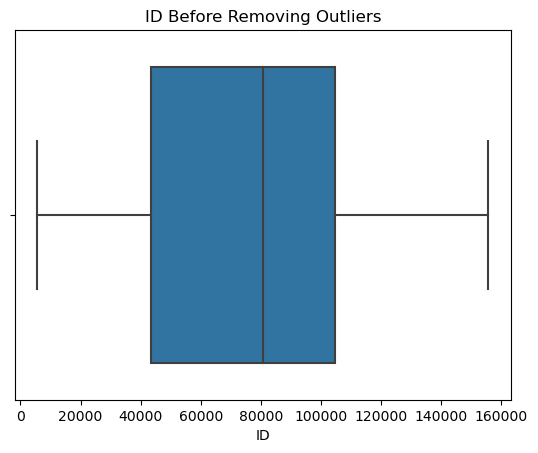

<IPython.core.display.Javascript object>

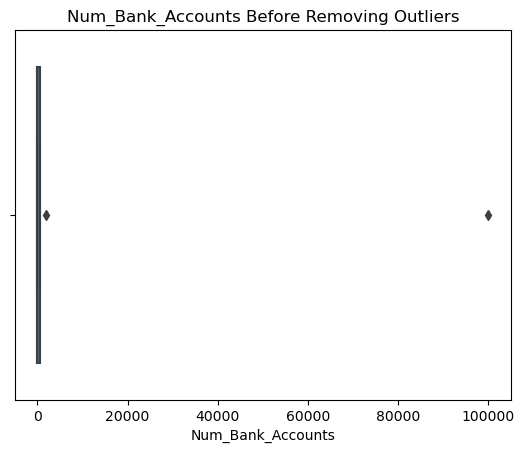

<IPython.core.display.Javascript object>

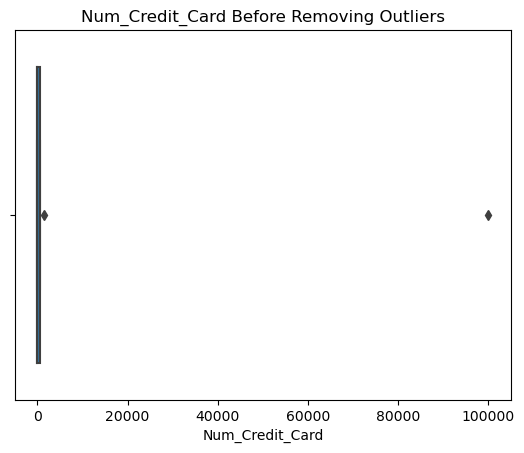

<IPython.core.display.Javascript object>

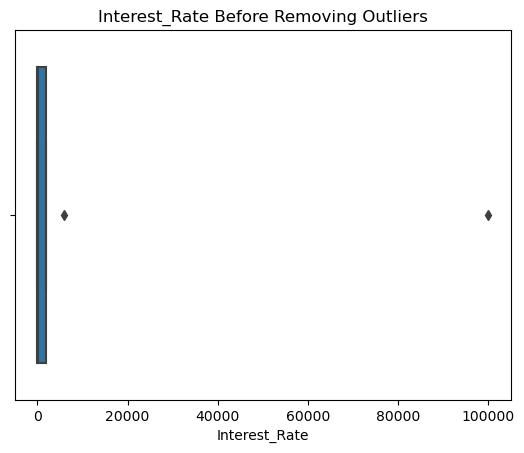

<IPython.core.display.Javascript object>

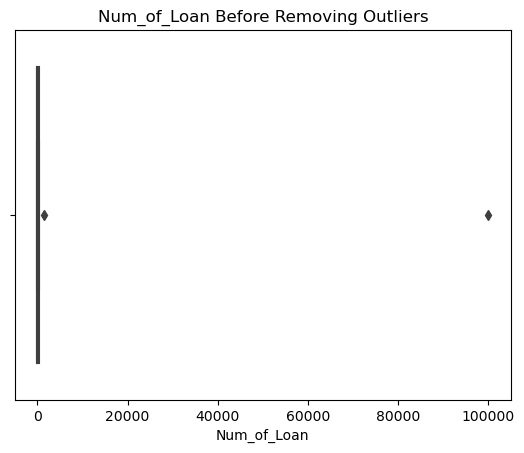

<IPython.core.display.Javascript object>

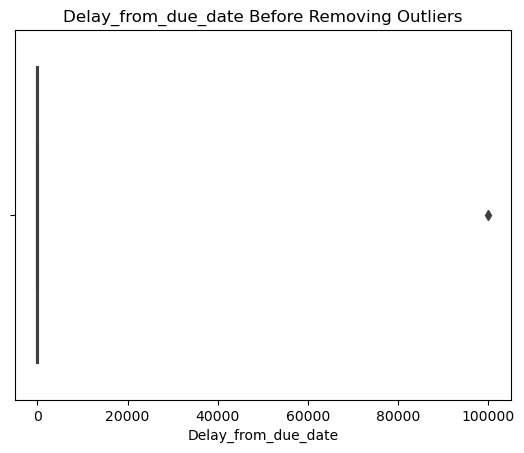

In [24]:
for feature in numeric_columns:
    #Seaborn boxplot for each numeric feature
    plt.clf()
    sns.boxplot(x=df[feature].describe()).set(title="{} Before Removing Outliers".format(feature))
    plt.show()

Some of the graphs contain extreme outliers, others contain normal variables as seen in the graphs

In [25]:
df['Age'].describe()

count    100000.000000
mean        119.509700
std         684.757313
min          14.000000
25%          25.000000
50%          34.000000
75%          42.000000
max        8698.000000
Name: Age, dtype: float64

From the histograms, we can see that there are extreme outliers in some of these features. For example, the higest value in the feature 'Age' is 8698, which is impossible. In this specific case, we can exclude all the rows with higher 'Age' than 118 as that is the age of the oldest living human.

In [26]:
df = df[df.Age <= 118] #Remove all the rows with Age over 118
print("{} rows with age above 118 have been removed".format(100000 - df.shape[0]))

2770 rows with age above 118 have been removed


From the histogram, we can see that there are quite a few extreme outliers in these features.

In [27]:
numeric_columns = list(df.dtypes[df.dtypes == "float64"].index.values) + list(df.dtypes[df.dtypes == "int64"].index.values) #Make a list of numerical columns

new_df = df.copy() #Copy df to new_df to preserve df
def remove_outliers(df, col):
    """
    Remove outliers from a given column of a pandas dataframe using mean and standard deviation method
    
    Parameters:
    df : pandas dataframe
        Dataframe from which to remove outliers
    col : string
        Name of column from which to remove outliers
        
    Returns:
    df : pandas dataframe
        Dataframe with outliers removed from the given column
    """
    mean = df[col].mean() #Calculate the mean of the column
    std = df[col].std() #Calculate the standard deviation of the column
    outliers = (df[col] - mean).abs() > 3*std #Calculate the outliers in the column by subtracting the mean from the column and then comparing it to 
    #3 standard deviations
    df_outliers = df.loc[~outliers, :] #Create a new dataframe with only the non outliers
    return df_outliers #Return the newly created dataframe

#Outliers can easily be reomved for 'Age' feature by removing entries with age more than 118 (oldest living person)

print("Shape of dataframe before removing outliers: {}".format(new_df.shape)) #Display the shape of the dataframe before removing outliers

for feature in numeric_columns:
    new_df = remove_outliers(new_df,feature)


print("Shape of dataframe after removing outliers: {}".format(new_df.shape)) #Display the shape of the dataframe after removing outliers
bef = df.shape[0] #Get the number of rows before removing outliers
aft = new_df.shape[0] #Get the number of rows after removing outliers
print("Number of outliers detected = {}".format(bef-aft)) #Display the number of outliers detected
df=new_df #Set the new_df as df

Shape of dataframe before removing outliers: (97230, 24)
Shape of dataframe after removing outliers: (83041, 24)
Number of outliers detected = 14189


Features Selection

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'Corelation Matrix')]

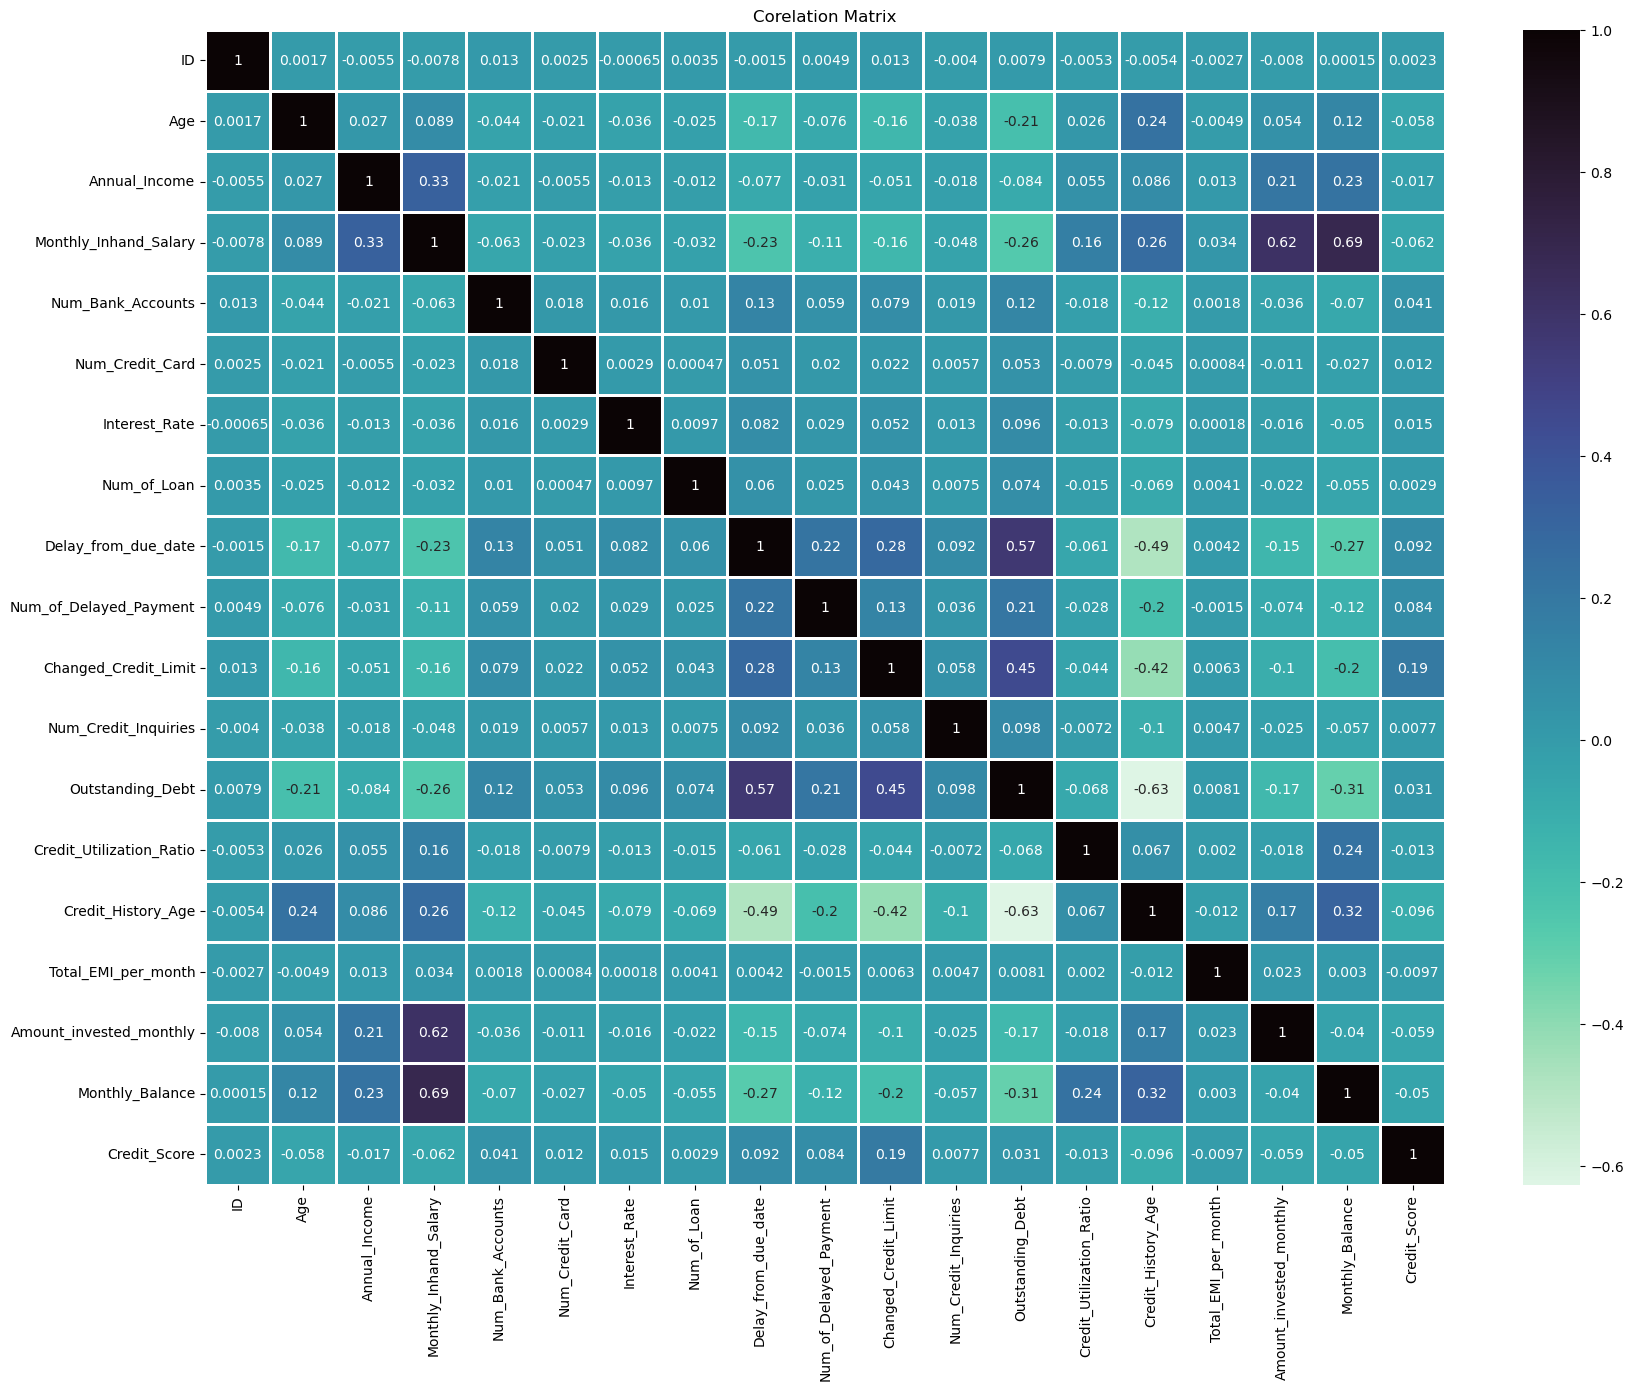

In [28]:
'''Create a heatmap of the correlation between different columns in the dataframe'''
plt.figure(figsize = (20,15)) #Set the figure size to 20x15
sns.heatmap(df.corr() , annot = True , cmap = "mako_r", linewidths=2).set(title="Corelation Matrix") #Create the heatmap of the correlation between different columns with annotations

<IPython.core.display.Javascript object>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Changed_Credit_Limit'),
  Text(1, 0, 'Credit_History_Age'),
  Text(2, 0, 'Delay_from_due_date'),
  Text(3, 0, 'Num_of_Delayed_Payment'),
  Text(4, 0, 'Monthly_Inhand_Salary'),
  Text(5, 0, 'Amount_invested_monthly'),
  Text(6, 0, 'Age'),
  Text(7, 0, 'Monthly_Balance'),
  Text(8, 0, 'Num_Bank_Accounts'),
  Text(9, 0, 'Outstanding_Debt'),
  Text(10, 0, 'Annual_Income'),
  Text(11, 0, 'Interest_Rate'),
  Text(12, 0, 'Credit_Utilization_Ratio'),
  Text(13, 0, 'Num_Credit_Card'),
  Text(14, 0, 'Total_EMI_per_month'),
  Text(15, 0, 'Num_Credit_Inquiries'),
  Text(16, 0, 'Num_of_Loan'),
  Text(17, 0, 'ID')])

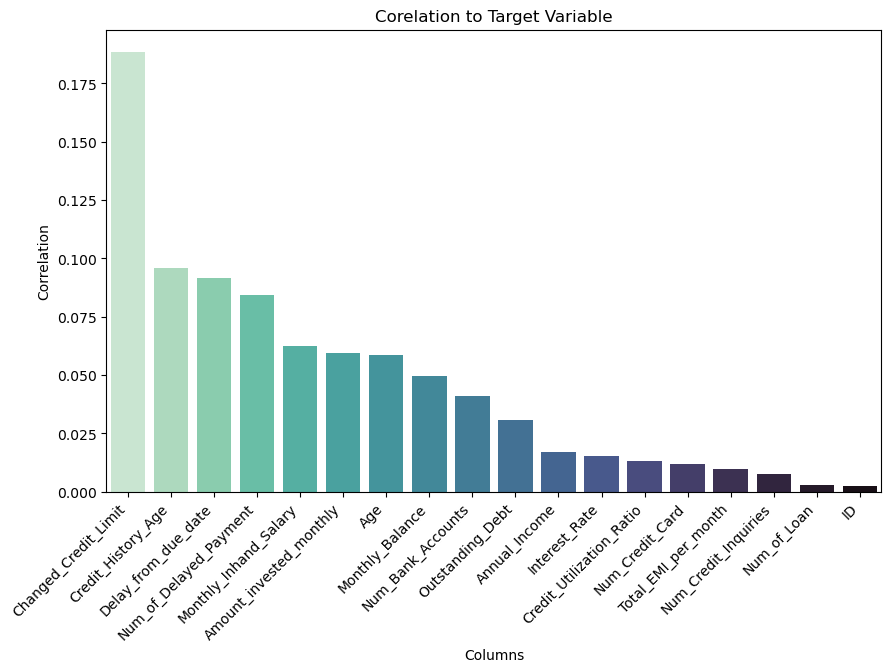

In [29]:
target_correlation = abs(df.corrwith(df['Credit_Score'])) #Calculate the correlation between the target variable and the other variables
target_correlation = pd.DataFrame({"cols":target_correlation.index,'corr':target_correlation.values}) #Put the calculated data in a dataframe
target_correlation = target_correlation[target_correlation.cols != 'Credit_Score'] #Remove the target variable from the created datafeame

'''Create a barplot that shows the correlation between the columns and the target variable.
The columns are sorted in order of descending correlation.'''
plt.figure(figsize=(10,6)) #Set the figure size to 10x6
sns.barplot(data=target_correlation, x='cols', y='corr', order=target_correlation.sort_values('corr',ascending = False).cols, palette='mako_r').set\
    (title="Corelation to Target Variable", xlabel='Columns', ylabel='Correlation') #Create the barplot
plt.xticks(rotation = 45, ha="right") #Rotate the labels on the x-axis by 45 degrees to make them fit

In [30]:
'''Since the correlation between the target variable and the features Total_EMI_per_month, Num_Credit_Inquiries, Nun_of_Loan and Num_Credit_Card are very
low, these features can be dropped to improve the model's efficiency'''
df.drop(columns=['Credit_Utilization_Ratio', 'Num_Credit_Card', 'Total_EMI_per_month', 'Num_Credit_Inquiries', 'Num_of_Loan', 'Credit_History_Age'], inplace = True)

Dealing with missing values

<IPython.core.display.Javascript object>

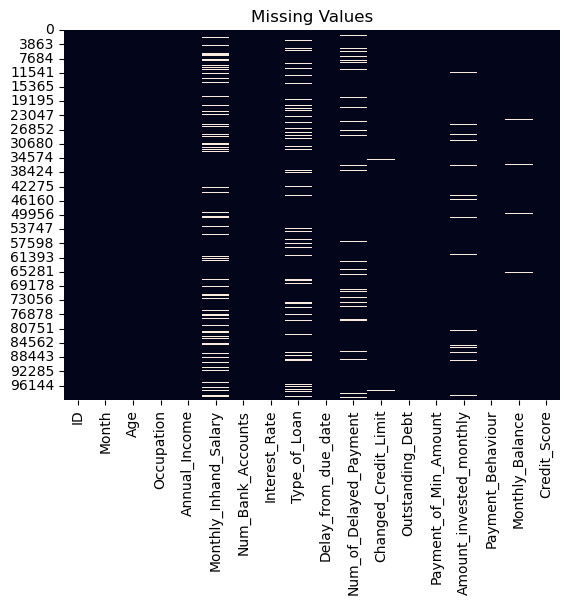

Number of outliers in each column:


ID                             0
Month                          0
Age                            0
Occupation                     0
Annual_Income                  0
Monthly_Inhand_Salary      12620
Num_Bank_Accounts              0
Interest_Rate                  0
Type_of_Loan                9497
Delay_from_due_date            0
Num_of_Delayed_Payment      5856
Changed_Credit_Limit        1754
Outstanding_Debt               0
Payment_of_Min_Amount          0
Amount_invested_monthly     3876
Payment_Behaviour              0
Monthly_Balance              979
Credit_Score                   0
dtype: int64

In [31]:
sns.heatmap(df.isnull(), cbar=False).set(title="Missing Values") #Plot a heatmap to visualise the missing variables in the dataframe
plt.show()
print("Number of outliers in each column:")
df.isnull().sum() #Get the number of missing values for each feature

In [32]:
na_columns = df.columns[df.isna().any()] #Create a series of columns with missing values
na_columns = list(na_columns) #Convert the series to list
na_columns

['Monthly_Inhand_Salary',
 'Type_of_Loan',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Amount_invested_monthly',
 'Monthly_Balance']

Since 'Type_of_Loan' is a categorical variable, we can convert all missing values with 'No Data' as that can be used in the model for prediction.

In [33]:
df['Type_of_Loan'] = df['Type_of_Loan'].fillna('No Data')
na_columns.remove('Type_of_Loan')

Data Imputation

In [34]:
numeric_columns = list(df.dtypes[df.dtypes == "float64"].index.values) + list(df.dtypes[df.dtypes == "int64"].index.values) #Create a list of numerical columns

new_df = df[numeric_columns] #Create a new dataframe with only the numerical columns
new_df.isna().sum() #Chech the number of missing values in each column

Age                            0
Annual_Income                  0
Monthly_Inhand_Salary      12620
Num_of_Delayed_Payment      5856
Changed_Credit_Limit        1754
Outstanding_Debt               0
Amount_invested_monthly     3876
Monthly_Balance              979
ID                             0
Num_Bank_Accounts              0
Interest_Rate                  0
Delay_from_due_date            0
Credit_Score                   0
dtype: int64

In [35]:
'''Imputing missing values'''
imputer = KNNImputer(n_neighbors=3) #Initialise the KNNImputer class with n_neighbors=3
imputed = imputer.fit_transform(new_df) #Use the fit_transform method to impute the missing values in new_df
df_imputed = pd.DataFrame(imputed, columns=new_df.columns) #Create a new dataframe called df_imputed with the imputed values

In [36]:
temp_df = df.copy() #Copy df to a new dataframe temp_df to not mutate the main dataframe
df_imputed.isna().sum() #Check if data imputation removed the missing values

Age                        0
Annual_Income              0
Monthly_Inhand_Salary      0
Num_of_Delayed_Payment     0
Changed_Credit_Limit       0
Outstanding_Debt           0
Amount_invested_monthly    0
Monthly_Balance            0
ID                         0
Num_Bank_Accounts          0
Interest_Rate              0
Delay_from_due_date        0
Credit_Score               0
dtype: int64

In [37]:
imputed_cols = df_imputed[['ID']+na_columns] #Create a new dataframe containing all of the columns with missing values in the original dataframe but from
#the imputed dataframe and the 'ID' column to help identify those columns
imputed_cols.columns #Check the columns of the new dataframe

Index(['ID', 'Monthly_Inhand_Salary', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Amount_invested_monthly', 'Monthly_Balance'],
      dtype='object')

In [38]:
temp_df.drop(columns=na_columns, inplace = True) #Drop the columns with missing values from the temp_df
temp_df.columns #Check the columns of the temp_df

Index(['ID', 'Month', 'Age', 'Occupation', 'Annual_Income',
       'Num_Bank_Accounts', 'Interest_Rate', 'Type_of_Loan',
       'Delay_from_due_date', 'Outstanding_Debt', 'Payment_of_Min_Amount',
       'Payment_Behaviour', 'Credit_Score'],
      dtype='object')

In [39]:
new_df = pd.merge(temp_df, imputed_cols, on='ID') #Merge the imputed columns and temp_df based on the 'ID'
new_df.isna().sum() #Check if the new_df has all the columns and if they have any missing values

ID                         0
Month                      0
Age                        0
Occupation                 0
Annual_Income              0
Num_Bank_Accounts          0
Interest_Rate              0
Type_of_Loan               0
Delay_from_due_date        0
Outstanding_Debt           0
Payment_of_Min_Amount      0
Payment_Behaviour          0
Credit_Score               0
Monthly_Inhand_Salary      0
Num_of_Delayed_Payment     0
Changed_Credit_Limit       0
Amount_invested_monthly    0
Monthly_Balance            0
dtype: int64

In [40]:
'''ID is no longer needed so can be dropped'''
new_df.drop('ID', axis=1, inplace=True)
new_df.shape

(83041, 17)

In [41]:
df = new_df

Exploratory Data Analysis (EDA)

In [42]:
df.shape #Get the shape of the data

(83041, 17)

In [43]:
df.describe() #Get descriptive statistics of the dataset

,Age,Annual_Income,Num_Bank_Accounts,Interest_Rate,Delay_from_due_date,Outstanding_Debt,Credit_Score,Monthly_Inhand_Salary,Num_of_Delayed_Payment,Changed_Credit_Limit,Amount_invested_monthly,Monthly_Balance
count,83041.000000,8.304100e+04,83041.000000,83041.000000,83041.000000,83041.000000,83041.000000,83041.000000,83041.000000,83041.000000,83041.000000,83041.000000
mean,33.313315,5.316869e+04,5.886032,18.581628,21.063752,1408.045618,1.357305,4114.662118,13.734842,10.410027,192.038509,398.206494
std,10.791287,1.106176e+05,11.483345,63.288110,14.738718,1125.808329,0.762811,3049.672856,14.487193,6.567126,191.433251,206.060050
min,14.000000,7.005930e+03,0.000000,1.000000,0.000000,0.230000,0.000000,303.645417,0.000000,0.000000,0.000000,0.007760
25%,24.000000,1.932871e+04,3.000000,8.000000,10.000000,565.260000,1.000000,1625.000000,9.000000,5.360000,72.405485,269.784622
50%,33.000000,3.682229e+04,6.000000,13.000000,18.000000,1164.350000,2.000000,3069.091667,14.000000,9.390000,128.382350,336.164543
75%,42.000000,7.111284e+04,7.000000,20.000000,28.000000,1923.540000,2.000000,5902.562500,18.000000,14.750000,233.938715,466.469910
max,56.000000,4.442389e+06,368.000000,1480.000000,65.000000,4888.390000,2.000000,13743.053333,700.000000,30.490000,1878.503880,1525.367708


<IPython.core.display.Javascript object>

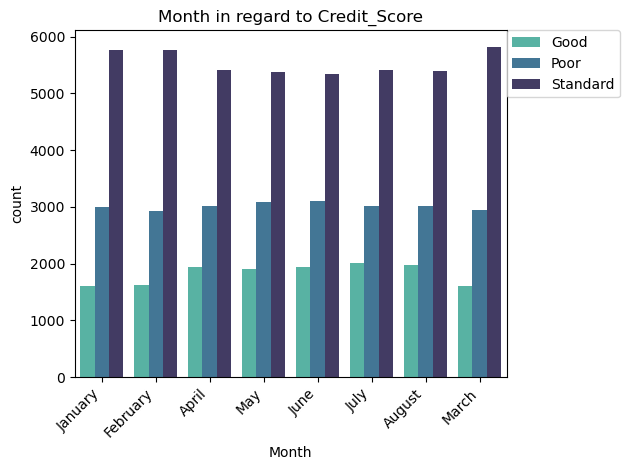

<IPython.core.display.Javascript object>

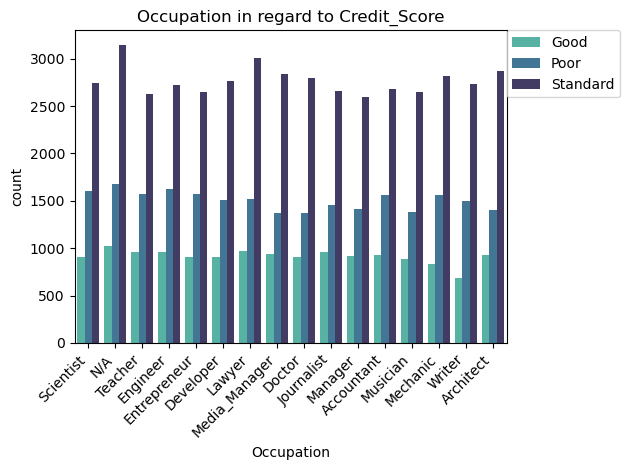

<IPython.core.display.Javascript object>

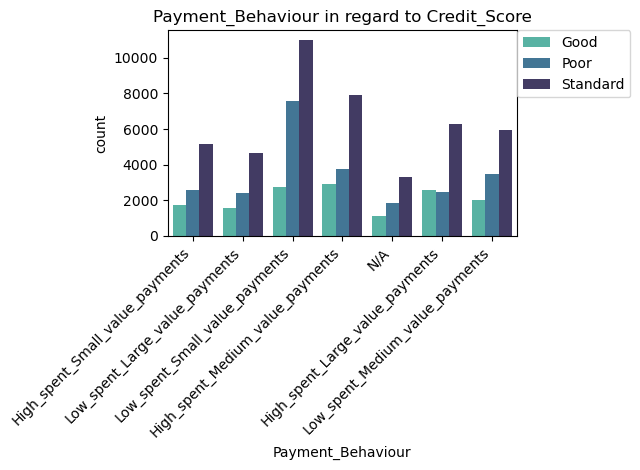

In [44]:
categorical_features = ['Month', 'Occupation', 'Payment_Behaviour'] #Create a list of the categorical features

'''Plotting the categorical variables'''
for feature in categorical_features: #Iterate over the categorical features
    plot = sns.countplot(x = df[feature], palette = 'mako_r', hue=df['Credit_Score']).set(title="{} in regard to Credit_Score".format(feature)) #Create a countplot for the feature with 'mako-r' palette
    plt.xticks(rotation=45, ha="right") #Rotate the labels on the x-axis by 45 degrees to make them fit
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,labels=['Good','Poor','Standard'])
    plt.tight_layout() #Automatically adjust subplot parameters so that the subplot fits in to the figure area
    plt.show() #Show the plot

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'Target Variable Distribution (Credit_Score)')]

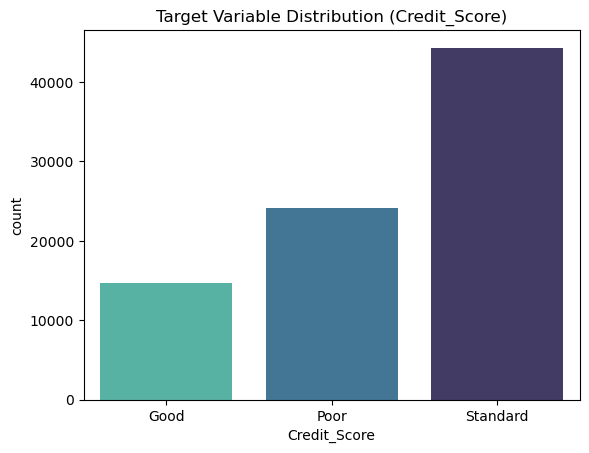

In [45]:
'''Target Variable'''
target = sns.countplot(x = df['Credit_Score'], palette = 'mako_r') #Plot a countplot for the target variable
target.set_xticklabels(['Good','Poor','Standard']) #Defining the labels
target.set(title="Target Variable Distribution (Credit_Score)") #Setting the title

<IPython.core.display.Javascript object>

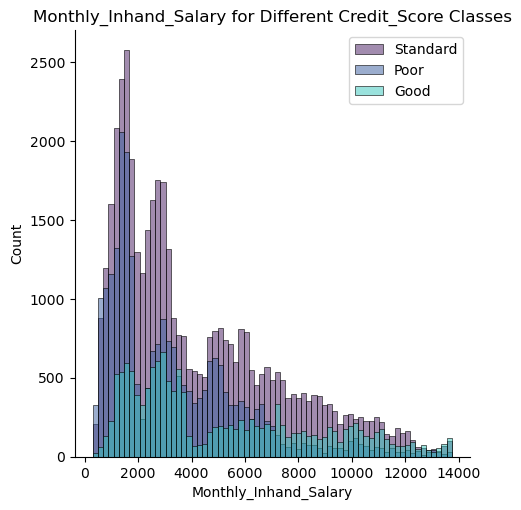

In [46]:
'''Draw a distribution plot for Monthly_Inhand_Salary with hue set to Credit_Score to visualise the correlation'''
plot = sns.displot(x='Monthly_Inhand_Salary',data=df, hue='Credit_Score',palette=['#36C6BC','#385D9F','#471A60'], legend=False).\
set(title="Monthly_Inhand_Salary for Different Credit_Score Classes")
plt.legend(labels=['Standard', 'Poor', 'Good']) #Define legends
plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Scientist'),
  Text(1, 0, 'N/A'),
  Text(2, 0, 'Teacher'),
  Text(3, 0, 'Engineer'),
  Text(4, 0, 'Entrepreneur'),
  Text(5, 0, 'Developer'),
  Text(6, 0, 'Lawyer'),
  Text(7, 0, 'Media_Manager'),
  Text(8, 0, 'Doctor'),
  Text(9, 0, 'Journalist'),
  Text(10, 0, 'Manager'),
  Text(11, 0, 'Accountant'),
  Text(12, 0, 'Musician'),
  Text(13, 0, 'Mechanic'),
  Text(14, 0, 'Writer'),
  Text(15, 0, 'Architect')])

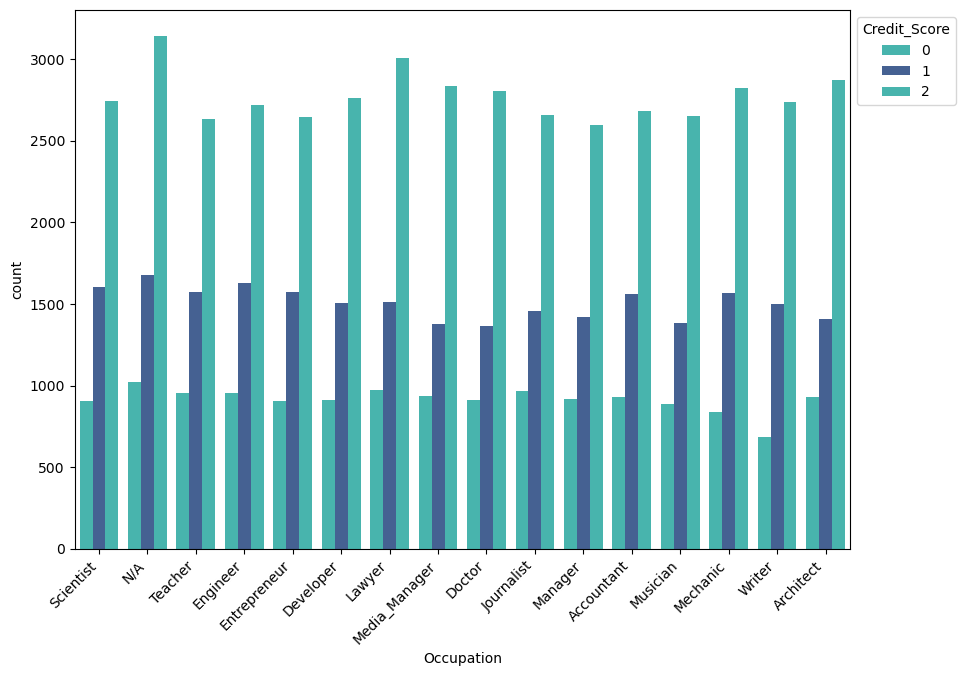

In [47]:
'''Plot a countplot to compare the Credit_Score of different Occupations'''
plt.figure(figsize=(10,7)) #Set the figure size to 10x7
plot = sns.countplot(x='Occupation',data=df, hue='Credit_Score',palette=['#36C6BC','#385D9F','#36C6BC']) #Plots a countplot of the feature Occupation with
#the hue set to Credit_Score.
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1)) #Move the legend to the top-right corner
plt.xticks(rotation = 45, ha="right") #Rotate the labels on the x-axis by 45 degrees to make them fit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

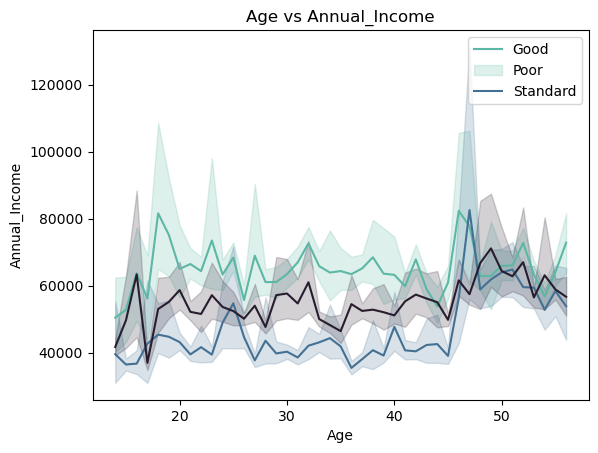

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

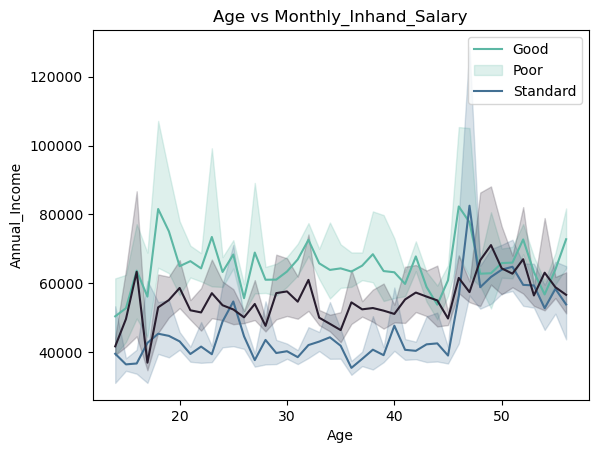

In [48]:
palette = ['#5CB7A4','#437093','#281D2E'] #Define the colour palette to be used for the plots
'''Plot a lineplot to see the relation between Age and Annual_Income'''
sns.lineplot(x = df.Age, y = df.Annual_Income, hue = df.Credit_Score, palette=sns.color_palette(palette, 3)).set(title="Age vs Annual_Income")
plt.legend(labels=['Good', 'Poor', 'Standard']) #Define legends
plt.show() #Display the plot
'''Plot a lineplot to see the relation between Age and Monthly_Inhand_Salary'''
sns.lineplot(x = df.Age, y = df.Annual_Income, hue = df.Credit_Score, palette=sns.color_palette(palette, 3)).set(title="Age vs Monthly_Inhand_Salary")
plt.legend(labels=['Good', 'Poor', 'Standard']) #Define legends
plt.show() #Display the plot

Feature Engineering

In [49]:
df.groupby('Type_of_Loan').count() #Check the number of unique values in the Type_of_Loan coloumn

,Month,Age,Occupation,Annual_Income,Num_Bank_Accounts,Interest_Rate,Delay_from_due_date,Outstanding_Debt,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score,Monthly_Inhand_Salary,Num_of_Delayed_Payment,Changed_Credit_Limit,Amount_invested_monthly,Monthly_Balance
Type_of_Loan,,,,,,,,,,,,,,,,
Auto Loan,961,961,961,961,961,961,961,961,961,961,961,961,961,961,961,961
"Auto Loan, Auto Loan, Auto Loan, Auto Loan, Credit-Builder Loan, Credit-Builder Loan, Mortgage Loan, and Personal Loan",8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
"Auto Loan, Auto Loan, Auto Loan, Auto Loan, Student Loan, and Student Loan",7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
"Auto Loan, Auto Loan, Auto Loan, Credit-Builder Loan, Payday Loan, Not Specified, Payday Loan, Student Loan, and Debt Consolidation Loan",8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
"Auto Loan, Auto Loan, Auto Loan, Not Specified, Debt Consolidation Loan, and Credit-Builder Loan",5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Student Loan, and Mortgage Loan",156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156
"Student Loan, and Not Specified",138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138
"Student Loan, and Payday Loan",229,229,229,229,229,229,229,229,229,229,229,229,229,229,229,229


Type_of_Loan feature is a categorical feature but has too many categories (6251). So, an alternate to OneHotEncoding needs to be used on this feature.
I decided to create a new column for each type of loan and enumerate them with the number of loans of that kind a person has.

In [50]:
'''This code splits up the data in each column of the dataframe according to commas, and then further splits it up according to 'and'. 
It appends each list to the total_list, which contains all of the lists. It also appends each list to loanTypes, which contains
all of the unique values in those lists.'''

df=new_df #Replace the main df of the project with the new_df for ease of use 
df['Type_of_Loan'] = df['Type_of_Loan'].fillna('No Data') #Replace missing values with 'No Data' to create a separate column for it

data = df[['Type_of_Loan']] #Select the Type_of_Loan column
total_list = [] #Create an empty list to store all of the list
loanTypes = [] #Create an empty list to store the types of loan (unique values)
for n in range(len(data)): #Iterate over the length of the data variable
    li = [i.strip().split(' ') for i in data.iloc[n,0].split(',')] #Split the data based on space and 
    #then creates a list where each element is a list containing the words that were originally separated by the commas
    new_li = [] #Create an empty list to store the new list created
    for l in li: #Iterate over the list of words
        if l[0]=='and': #If the first word is 'and'
            l[0]='' #Remove the 'and'
        new_li.append(' '.join(l).strip()) #Store the new list of words in new_li
    loanTypes.extend(new_li) #Add the loan types to the list
    total_list.append(new_li) #Add the new row into the list of all rows

loanTypes = set(loanTypes) #Convert the loanTypes to a set
loanTypes = list(loanTypes) #Convert the loanTypes to a list
loanTypes

['Mortgage Loan',
 'Debt Consolidation Loan',
 'Student Loan',
 'Personal Loan',
 'Not Specified',
 'Credit-Builder Loan',
 'Home Equity Loan',
 'No Data',
 'Payday Loan',
 'Auto Loan']

In [51]:
def list_to_dict(lst):
  '''
    Convert a list to dictionary with the list elements as the keys and empty lists as the values
  
    Parameters:
    lst (list): A list to be converted
  
    Returns:
    dict: A dictionary with each input list element as the keys and empty lists as their values

  '''
  d = {} #Creare an empty dictionary
  for i in lst: #Iterate over the lit
    d[i] = [] #Add the element as the key and empty list as its value
  return d #Return the dictionary

In [52]:
newList = [] #Create an empty list to store the dictionaries in

for row in total_list: #Iterate over the lists in total_list
    x = Counter(row) #Count each unique element in the corresponding list in total_list
    newList.append(dict(x)) #Append x as a dictionary to newList

len(newList)

83041

In [53]:
newDict = list_to_dict(loanTypes) #Create a new dictionary with each of the loan types

'''Count the types of loan each entry has and adding it to the ditctionary as a list'''
for dictionary in newList: #Iterate through the list of dicitonaries
    used = [] #Create an empty list
    for key,value in dictionary.items(): #For each key (type of loan) and value (number of loan of that type) in the dictionary
        newDict[key].append(value) #Append the value to the key in the newDict dictionary
        used.append(key) #Append the key to the used list
    for loanType in loanTypes: #Iterate over loanTypes (types of loan)
        if loanType not in used: #If loan type is not in the used list
            newDict[loanType].append(0) #Append 0 to that loan type

In [54]:
#Adding the lists created in the dictionary as new columns to replace the 'Type_of_Loan' column
for key, value in newDict.items(): #Iterate through the key (type of loan) and values (number of loan of that type) of the newDict dictionary
    df[key] = value #Add the value to the corresponding column in the dataframe

df.head() 

,Month,Age,Occupation,Annual_Income,Num_Bank_Accounts,Interest_Rate,Type_of_Loan,Delay_from_due_date,Outstanding_Debt,Payment_of_Min_Amount,...,Mortgage Loan,Debt Consolidation Loan,Student Loan,Personal Loan,Not Specified,Credit-Builder Loan,Home Equity Loan,No Data,Payday Loan,Auto Loan
0,January,23.0,Scientist,19114.12,3,3,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,809.98,No,...,0,0,0,1,0,1,1,0,0,1
1,February,23.0,Scientist,19114.12,3,3,"Auto Loan, Credit-Builder Loan, Personal Loan,...",1,809.98,No,...,0,0,0,1,0,1,1,0,0,1
2,April,23.0,Scientist,19114.12,3,3,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,809.98,No,...,0,0,0,1,0,1,1,0,0,1
3,May,23.0,Scientist,19114.12,3,3,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,809.98,No,...,0,0,0,1,0,1,1,0,0,1
4,June,23.0,Scientist,19114.12,3,3,"Auto Loan, Credit-Builder Loan, Personal Loan,...",8,809.98,No,...,0,0,0,1,0,1,1,0,0,1


In [55]:
df.drop(columns=['Type_of_Loan'], inplace=True, axis=1) #Drop 'Type_of_Loan' column
df.head()

,Month,Age,Occupation,Annual_Income,Num_Bank_Accounts,Interest_Rate,Delay_from_due_date,Outstanding_Debt,Payment_of_Min_Amount,Payment_Behaviour,...,Mortgage Loan,Debt Consolidation Loan,Student Loan,Personal Loan,Not Specified,Credit-Builder Loan,Home Equity Loan,No Data,Payday Loan,Auto Loan
0,January,23.0,Scientist,19114.12,3,3,3,809.98,No,High_spent_Small_value_payments,...,0,0,0,1,0,1,1,0,0,1
1,February,23.0,Scientist,19114.12,3,3,1,809.98,No,Low_spent_Large_value_payments,...,0,0,0,1,0,1,1,0,0,1
2,April,23.0,Scientist,19114.12,3,3,5,809.98,No,Low_spent_Small_value_payments,...,0,0,0,1,0,1,1,0,0,1
3,May,23.0,Scientist,19114.12,3,3,6,809.98,No,High_spent_Medium_value_payments,...,0,0,0,1,0,1,1,0,0,1
4,June,23.0,Scientist,19114.12,3,3,8,809.98,No,N/A,...,0,0,0,1,0,1,1,0,0,1


In [56]:
df.dtypes

Month                       object
Age                        float64
Occupation                  object
Annual_Income              float64
Num_Bank_Accounts            int64
Interest_Rate                int64
Delay_from_due_date          int64
Outstanding_Debt           float64
Payment_of_Min_Amount       object
Payment_Behaviour           object
Credit_Score                 int64
Monthly_Inhand_Salary      float64
Num_of_Delayed_Payment     float64
Changed_Credit_Limit       float64
Amount_invested_monthly    float64
Monthly_Balance            float64
Mortgage Loan                int64
Debt Consolidation Loan      int64
Student Loan                 int64
Personal Loan                int64
Not Specified                int64
Credit-Builder Loan          int64
Home Equity Loan             int64
No Data                      int64
Payday Loan                  int64
Auto Loan                    int64
dtype: object

In [57]:
print("Number of non-numeric features = {}".format((df.dtypes=='object').sum()))

Number of non-numeric features = 4


In [58]:
object_columns.remove('Type_of_Loan') #Remove 'Type_of_Loan' from object_columns list since it's no longer in the dataframe
object_columns

['Month',
 'Occupation',
 'Credit_History_Age',
 'Payment_of_Min_Amount',
 'Payment_Behaviour']

In [59]:
'''Convert the categorical variables into numerical variables for Machine Learning'''
encoded_data = pd.get_dummies(df) #Encode data in a dataframe using one hot encoding\

In [60]:
print("Number of non-numeric features = {}".format((encoded_data.dtypes=='object').sum()))

Number of non-numeric features = 0


In [61]:
df = encoded_data #Save the encoded_data into df (the main dataset)


Splitting the Data into Training and Testing Data

In [62]:
X = df.drop('Credit_Score', axis=1) #Select all the columns except Credit_Score as X
y = df['Credit_Score'] #Select Credit_Score as y (target variable)

In [63]:
'''Split the dataset for training and testing data mainintaining the proportion of the original data to make the testing more realistic and comparable to the real-world'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

In [64]:
print("Original data: \n{}".format(df['Credit_Score'].value_counts(normalize=True)*100)) #Original Data: Print the percentage of each class in the target variable
print("Training data: \n{}".format(y_train.value_counts(normalize=True)*100)) #Training Data: Print the percentage of each class in the target variable
print("Testing data: \n{}".format(y_test.value_counts(normalize=True)*100)) #Test Data: Print the percentage of each class in the target variable

Original data: 
2    53.342325
1    29.045893
0    17.611782
Name: Credit_Score, dtype: float64
Training data: 
2    53.341763
1    29.046243
0    17.611994
Name: Credit_Score, dtype: float64
Testing data: 
2    53.344572
1    29.044494
0    17.610934
Name: Credit_Score, dtype: float64


Balancing

In [65]:
'''Balancing needs to be performed only to the training dataset after splitting to prevent data leakage'''

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("Training data: \n{}".format(y_res.value_counts(normalize=True)*100)) #Training Data: Print the percentage of each class in the target variable after balancing
print(y_res.shape) #Print the shape of y_res to see if the number of rows has gone up

Training data: 
0    33.333333
1    33.333333
2    33.333333
Name: Credit_Score, dtype: float64
(106308,)


In [66]:
X_train, y_train = X_res, y_res #Set the X_train and y_train to the newly made X_res and y_res

Scaling

In [67]:
'''The scalar should be fitterd using the training to fit both the training and testing data'''
scaler = StandardScaler().fit(X_train)
train_sc = scaler.transform(X_train)
test_sc = scaler.transform(X_test)

Machine Learning

In [68]:
def trainModel(algorithm, X_train, X_test, y_train, y_test):
    '''
    Trains the model and returns accuracy and classification report.

        Parameters:
                algorithm: A machine learning algorithm
                X_train (array): Array of training data
                X_test (array): Array of testing data
                y_train (array): Array of training labels
                y_test (array): Array of testing labels

        Returns:
                accuracy (float): A float rounded to 3 decimal places representing the accuracy of the model
                classification_report (string): A string of the classification report

     ''' 

    algorithm.fit(X_train, y_train) #Fit the model

    y_train_predict = algorithm.predict(X_train) #Predict the target on the train dataset
    
    y_test_predict = algorithm.predict(X_test) #Predict the target on the test dataset
    
    train_accuracy = accuracy_score(y_train, y_train_predict) #Get the accuracy for y_train
    test_accuracy = accuracy_score(y_test, y_test_predict) #Get the accuracy for y_test
    
    train_report = classification_report(y_train, y_train_predict) #Get the classification report
    test_report = classification_report(y_test, y_test_predict) #Get the classification report
    
    return y_train_predict, y_test_predict, train_accuracy, test_accuracy, train_report, test_report #Return the results

#     algorithm.fit(X_train, y_train) #Fit the given model
#     prediction = algorithm.predict(X_test) #Make predictions based on the learned data
#     return round(metrics.accuracy_score(y_test, prediction), 3), classification_report(y_test, prediction, target_names = ['Negative', 'Positive']) #Return the accuracy and the classification report of the predictions

Random Forest Classifier
Training Data: 
 Accuracy = 0.7261353802159762
              precision    recall  f1-score   support

           0       0.68      0.89      0.77     35436
           1       0.76      0.75      0.75     35436
           2       0.77      0.54      0.63     35436

    accuracy                           0.73    106308
   macro avg       0.74      0.73      0.72    106308
weighted avg       0.74      0.73      0.72    106308

Testing Data: 
 Accuracy = 0.6497681979649588
              precision    recall  f1-score   support

           0       0.45      0.79      0.57      2925
           1       0.65      0.75      0.70      4824
           2       0.83      0.55      0.66      8860

    accuracy                           0.65     16609
   macro avg       0.64      0.70      0.64     16609
weighted avg       0.71      0.65      0.65     16609



<IPython.core.display.Javascript object>

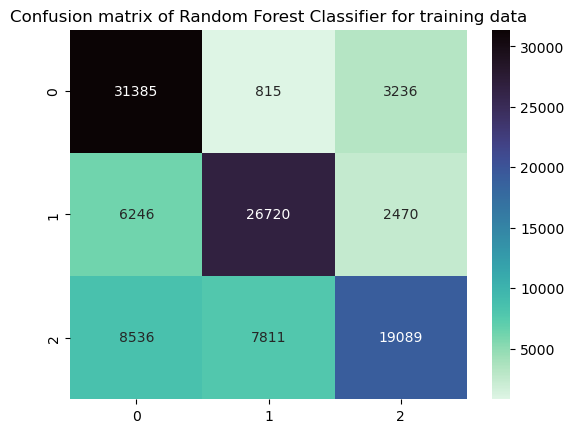

<IPython.core.display.Javascript object>

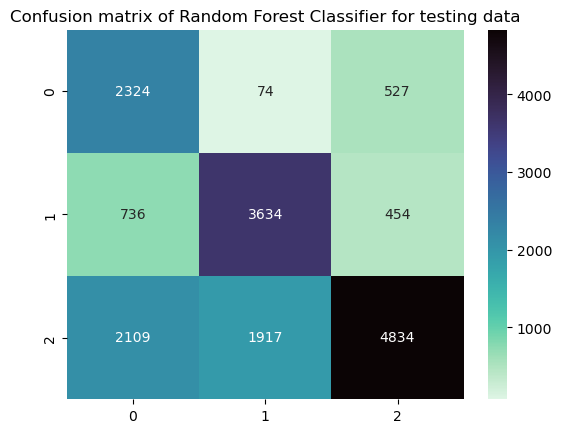

K-nearest Neighbors Classifier
Training Data: 
 Accuracy = 0.8825582270384167
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     35436
           1       0.87      0.95      0.91     35436
           2       0.92      0.73      0.81     35436

    accuracy                           0.88    106308
   macro avg       0.89      0.88      0.88    106308
weighted avg       0.89      0.88      0.88    106308

Testing Data: 
 Accuracy = 0.7205129748931303
              precision    recall  f1-score   support

           0       0.55      0.79      0.65      2925
           1       0.71      0.84      0.77      4824
           2       0.84      0.63      0.72      8860

    accuracy                           0.72     16609
   macro avg       0.70      0.75      0.71     16609
weighted avg       0.75      0.72      0.72     16609



<IPython.core.display.Javascript object>

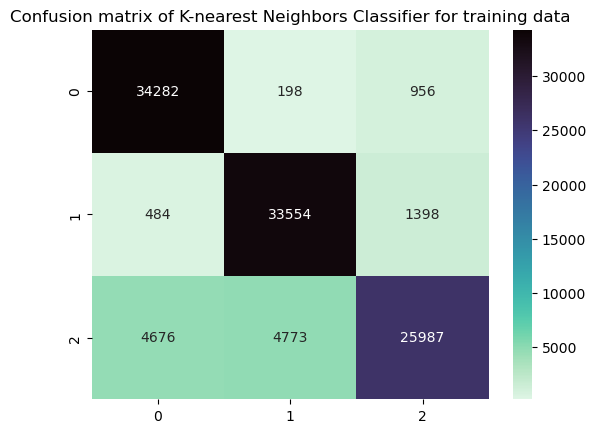

<IPython.core.display.Javascript object>

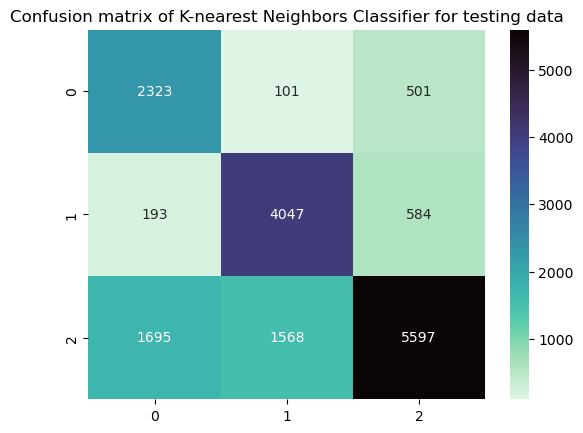

Gradient Boosting Classifier
Training Data: 
 Accuracy = 0.8222617300673515
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     35436
           1       0.86      0.78      0.82     35436
           2       0.78      0.79      0.79     35436

    accuracy                           0.82    106308
   macro avg       0.82      0.82      0.82    106308
weighted avg       0.82      0.82      0.82    106308

Testing Data: 
 Accuracy = 0.7231019326870973
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      2925
           1       0.75      0.69      0.72      4824
           2       0.75      0.77      0.76      8860

    accuracy                           0.72     16609
   macro avg       0.70      0.70      0.70     16609
weighted avg       0.72      0.72      0.72     16609



<IPython.core.display.Javascript object>

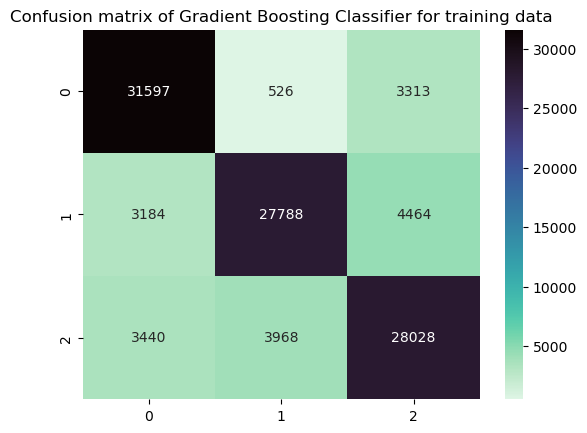

<IPython.core.display.Javascript object>

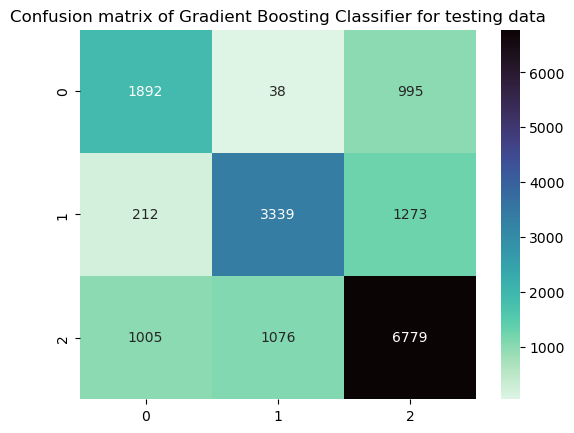

In [69]:
algorithms = [RandomForestClassifier(max_depth=8), KNeighborsClassifier(), HistGradientBoostingClassifier()] #Define algorithms to be used
algorithm_names = ['Random Forest Classifier', 'K-nearest Neighbors Classifier', 'Gradient Boosting Classifier']

initial_results = [] #Create an empty list
for algorithm in range(len(algorithms)): #Loop through the length of the list of algorithms
    train_pred, test_pred, train_accuracy, test_accuracy, train_report, test_report = trainModel(algorithms[algorithm], X_train, X_test, y_train, y_test) #Train the model using the
    #trainModel function and get the results
    print(algorithm_names[algorithm]) #Print the name of the algorithm
    print("Training Data: \n Accuracy = {}\n{}".format(train_accuracy, train_report)) #Display the accuracy and classification report for the specific algorithm
    print("Testing Data: \n Accuracy = {}\n{}".format(test_accuracy, test_report)) #Display the accuracy and classification report for the specific algorithm

    cm_train = confusion_matrix(y_train,train_pred) #Get the confusion matrix for the training predictions
    cm_test = confusion_matrix(y_test,test_pred) #Get the confusion matrix for the testing predictions

    initial_results.append({
        'Algorithm':algorithm_names[algorithm],
        'Training Accuracy':train_accuracy,
        'Testing Accuracy':test_accuracy
    }) #Store the results for later comparision

    '''Displaying the Heatmaps'''
    plt.clf() #Clear the plot
    sns.heatmap(cm_train, annot=True, fmt='g', cmap='mako_r').set(title="Confusion matrix of {} for training data".format(algorithm_names[algorithm])) #Create a heatmap using the 
    #seaborn library from the cm_train matrix with annotated values, formatting the numbers as 'g' and using the mako_r color palette
    plt.show() #Display the heatmap
    plt.clf() #Clear the plot
    sns.heatmap(cm_test, annot=True, fmt='g', cmap='mako_r').set(title="Confusion matrix of {} for testing data".format(algorithm_names[algorithm])) #Create a heatmap using the seaborn
    #library from the cm_test matrix with annotated values, formatting the numbers as 'g' and using the mako_r color palette
    plt.show() #Display the heatmap

<Figure size 640x480 with 0 Axes>

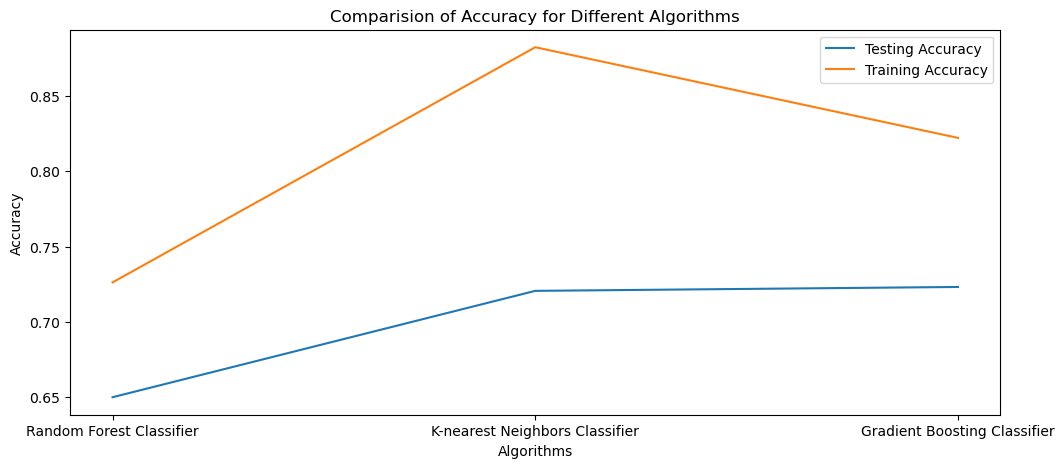

In [70]:
initial_comparision = pd.DataFrame(initial_results)

plt.clf() #Clears any existing plot from the current figure
plt.figure(figsize=(12,5)) #Create a new figure with a size of (12,5)

'''Plots the columns 'Algorithm' and 'Testing Accuracy' from initial_comparision dataframe and label it as 'Training Accuracy'''
plt.plot(initial_comparision['Algorithm'], initial_comparision['Testing Accuracy'], label='Testing Accuracy')

'''Plots the columns 'Algorithm' and 'Training Accuracy' from initial_comparision dataframe and label it as 'Training Accuracy'''
plt.plot(initial_comparision['Algorithm'], initial_comparision['Training Accuracy'], label='Training Accuracy')

plt.xlabel("Algorithms")  #Set x-axis label as Algorithms
plt.ylabel("Accuracy") #Set y-axis labels as Accuracy
plt.legend() #Create a legend
plt.title('Comparision of Accuracy for Different Algorithms') #Set the title
plt.show() #Show the diagram

Grid Search

In [71]:
def run_model(algorithm, X_train, X_test, y_train, y_test, parameters):
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=0) #Create an instance of the RepeatedStratifiedKFold class, which is part of the scikit-learn library
    gridSearch = GridSearchCV(estimator=algorithm(), param_grid=parameters, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0) #Create an instance of the GridSearchCV class
    model = gridSearch.fit(X_train,y_train) #Fit the model to the data using the GridSearchCV instance
    preds = model.predict(X_test) #Make predictions based on the trained model
    optimalParmeter = model.best_params_ #Get the optimal parameters for the model
    if optimalParmeter == {}: #Check to see if the optimal parameters are the default
        optimalParmeter = 'default'#If the optimal parameters are default, set it as such
    else:
        print("Best result: {} with parameters {}".format(model.best_score_, optimalParmeter)) #If not, print the optimal parameters for that algorithm
    return model.best_score_,model.best_params_ #Return the best score and the best parameters for that model

In [72]:
algorithms = [RandomForestClassifier, KNeighborsClassifier, HistGradientBoostingClassifier] #Define algorithms to be used
rf= {
    'n_estimators': [100, 200, 300],
    'max_depth' : [8, 10, 12, 14],
    'criterion' :['gini', 'entropy']
} #Define the hyperparameters for RandomForestClassifier

knn = {
    'weights': ['distance'], 
    'n_neighbors': list(range(1,17,2)),
    'metric' : ['manhattan']
} #Define the hyperparameters for KNeighborsClassifier

gb = {
    'learning_rate': [0.01, 0.1, 1],
    'max_leaf_nodes': [20, 30, 40, 50],
    'max_depth' : [75, 100, 125]
} #Define the hyperparameters for HistGradientBoostingClassifier

model_parameters = [rf,knn,gb] #Make a list of the hyperparameters 
tuned_list = [] #Create an empty list to store the hypertuned parameters

for parameter_index in range(len(model_parameters)): #Loop through all the model parameters 
    score,parameters = run_model(algorithms[parameter_index],X_train,X_test,y_train,y_test,model_parameters[parameter_index]) #For each iteration, run the model and assign the resulting 
    #score and parameters to the score and parameters variables
    print(algorithm_names[parameter_index],":",score) #Print the algorithm name and score
    print() #Print an empty line
    tuned_list.append({"Algorithm":algorithm_names[parameter_index],"Score":score, "Parameters":parameters}) #Append the algorithm name, score and parameters to the tuned_list


Best result: 0.7590303646009708 with parameters {'criterion': 'gini', 'max_depth': 14, 'n_estimators': 100}
Random Forest Classifier : 0.7590303646009708

Best result: 0.8447717951612296 with parameters {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
K-nearest Neighbors Classifier : 0.8447717951612296

Best result: 0.8087161831658953 with parameters {'learning_rate': 0.1, 'max_depth': 75, 'max_leaf_nodes': 50}
Gradient Boosting Classifier : 0.8087161831658953



Running the models with optimum hyperparameters to get detailed report

{'Algorithm': 'Random Forest Classifier', 'Score': 0.7590303646009708, 'Parameters': {'criterion': 'gini', 'max_depth': 14, 'n_estimators': 100}}
{'Algorithm': 'K-nearest Neighbors Classifier', 'Score': 0.8447717951612296, 'Parameters': {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}}
{'Algorithm': 'Gradient Boosting Classifier', 'Score': 0.8087161831658953, 'Parameters': {'learning_rate': 0.1, 'max_depth': 75, 'max_leaf_nodes': 50}}
Random Forest Classifier
Training Data: 
 Accuracy = 0.8063080859389697
              precision    recall  f1-score   support

           0       0.75      0.92      0.83     35436
           1       0.83      0.82      0.82     35436
           2       0.86      0.68      0.76     35436

    accuracy                           0.81    106308
   macro avg       0.81      0.81      0.80    106308
weighted avg       0.81      0.81      0.80    106308

Testing Data: 
 Accuracy = 0.6845686073815401
              precision    recall  f1-score   

<IPython.core.display.Javascript object>

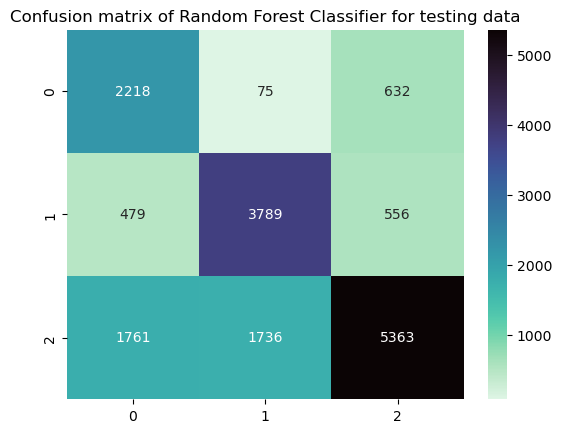

K-nearest Neighbors Classifier
Training Data: 
 Accuracy = 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35436
           1       1.00      1.00      1.00     35436
           2       1.00      1.00      1.00     35436

    accuracy                           1.00    106308
   macro avg       1.00      1.00      1.00    106308
weighted avg       1.00      1.00      1.00    106308

Testing Data: 
 Accuracy = 0.7646456740321512
              precision    recall  f1-score   support

           0       0.67      0.75      0.71      2925
           1       0.75      0.81      0.78      4824
           2       0.81      0.75      0.78      8860

    accuracy                           0.76     16609
   macro avg       0.75      0.77      0.76     16609
weighted avg       0.77      0.76      0.77     16609



<IPython.core.display.Javascript object>

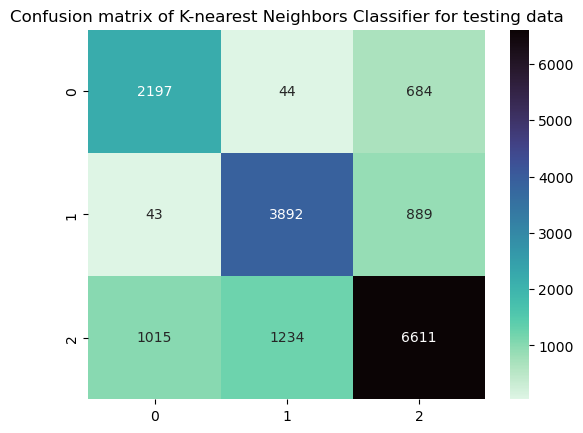

Gradient Boosting Classifier
Training Data: 
 Accuracy = 0.8500395078451293
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     35436
           1       0.88      0.82      0.85     35436
           2       0.82      0.81      0.82     35436

    accuracy                           0.85    106308
   macro avg       0.85      0.85      0.85    106308
weighted avg       0.85      0.85      0.85    106308

Testing Data: 
 Accuracy = 0.7430308868685652
              precision    recall  f1-score   support

           0       0.64      0.68      0.66      2925
           1       0.76      0.72      0.74      4824
           2       0.77      0.78      0.77      8860

    accuracy                           0.74     16609
   macro avg       0.72      0.73      0.72     16609
weighted avg       0.74      0.74      0.74     16609



<IPython.core.display.Javascript object>

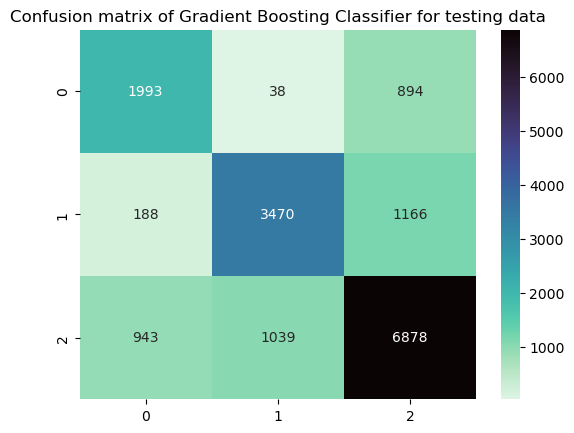

In [73]:
for params in tuned_list:
    print(params)

algorithms = [RandomForestClassifier(n_estimators= 100, max_depth = 14, criterion ='gini'), \
    KNeighborsClassifier(weights= 'distance', n_neighbors = 3, metric = 'manhattan'), \
        HistGradientBoostingClassifier(learning_rate = 0.1 , max_leaf_nodes = 50, max_depth = 100)] #Define algorithms to be used
algorithm_names = ['Random Forest Classifier', 'K-nearest Neighbors Classifier', 'Gradient Boosting Classifier']

testing_results = [] #Create an empty list to store results

for algorithm in range(len(algorithms)): #Loop through the length of the list of algorithms
    train_pred, test_pred, train_accuracy, test_accuracy, train_report, test_report = trainModel(algorithms[algorithm], X_train, X_test, y_train, y_test) #Train the model using the
    #trainModel function and get the results
    print(algorithm_names[algorithm]) #Print the name of the algorithm
    print("Training Data: \n Accuracy = {}\n{}".format(train_accuracy, train_report)) #Display the accuracy and classification report for the specific algorithm
    print("Testing Data: \n Accuracy = {}\n{}".format(test_accuracy, test_report)) #Display the accuracy and classification report for the specific algorithm

    cm_train = confusion_matrix(y_train,train_pred) #Get the confusion matrix for the training predictions
    cm_test = confusion_matrix(y_test,test_pred) #Get the confusion matrix for the testing predictions

    testing_results.append({
        'Algorithm':algorithm_names[algorithm],
        'Testing Accuracy':test_accuracy
    }) #Add the results to the list
    

    '''Displaying the Heatmaps'''
    plt.clf() #Clear the plot
    sns.heatmap(cm_test, annot=True, fmt='g', cmap='mako_r').set(title="Confusion matrix of {} for testing data".format(algorithm_names[algorithm])) #Create a heatmap using the seaborn
    #library from the cm_test matrix with annotated values, formatting the numbers as 'g' and using the mako_r color palette
    plt.show()

<Figure size 640x480 with 0 Axes>

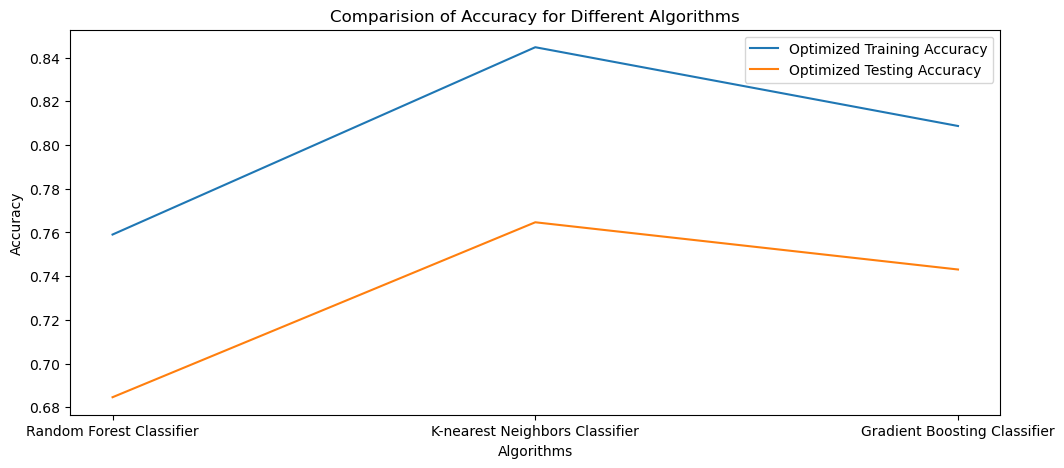

In [76]:
score_comparision = pd.DataFrame(tuned_list) #Create a dataframe of the tuned_list
score_comparision = score_comparision.iloc[:,:-1] #Remove the last column

test_accuracy_comparision = pd.DataFrame(testing_results) #Create a dataframe of the testing_results

plt.clf() #Clears any existing plot from the current figure
plt.figure(figsize=(12,5)) #Create a new figure with a size of (12,5)

'''Plots the columns 'Algorithm' and 'Score' from score_comparision dataframe and label it as 'Training Accuracy'''
plt.plot(score_comparision['Algorithm'], score_comparision['Score'], label='Optimized Training Accuracy')

'''Plots the columns 'Algorithm' and 'Testing Accuracy' from test_accuracy_comparision dataframe and label it as 'Testing Accuracy'''
plt.plot(test_accuracy_comparision['Algorithm'], test_accuracy_comparision['Testing Accuracy'], label='Optimized Testing Accuracy')

plt.xlabel("Algorithms") #Set x-axis label as Algorithms
plt.ylabel("Accuracy") #Set y-axis labels as Accuracy
plt.legend() #Create a legend
plt.title('Comparision of Accuracy for Different Algorithms') #Set the title
plt.show() #Show the diagram

<Figure size 640x480 with 0 Axes>

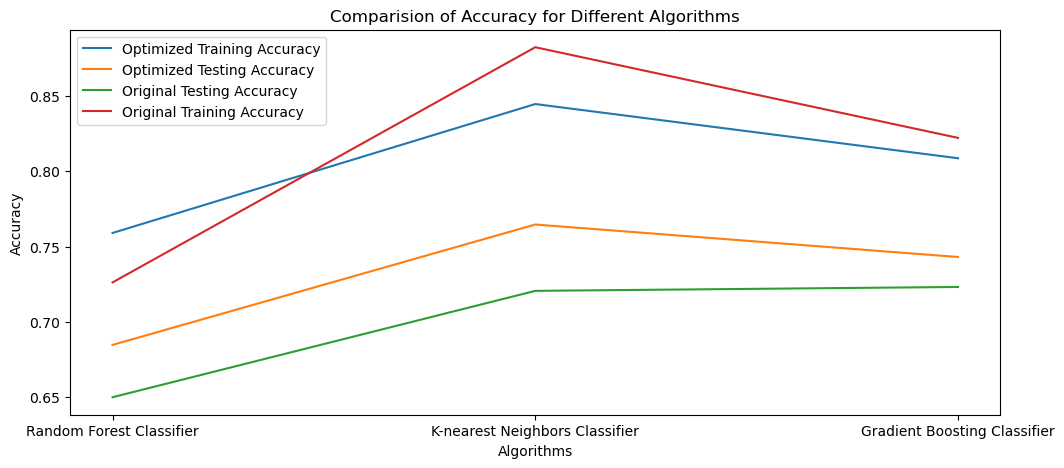

In [75]:
plt.clf() #Clears any existing plot from the current figure
plt.figure(figsize=(12,5)) #Create a new figure with a size of (12,5)

'''Plots the columns 'Algorithm' and 'Score' from score_comparision dataframe and label it as 'Training Accuracy'''
plt.plot(score_comparision['Algorithm'], score_comparision['Score'], label='Optimized Training Accuracy')

'''Plots the columns 'Algorithm' and 'Testing Accuracy' from test_accuracy_comparision dataframe and label it as 'Testing Accuracy'''
plt.plot(test_accuracy_comparision['Algorithm'], test_accuracy_comparision['Testing Accuracy'], label='Optimized Testing Accuracy')

'''Plots the columns 'Algorithm' and 'Testing Accuracy' from initial_comparision dataframe and label it as 'Training Accuracy'''
plt.plot(initial_comparision['Algorithm'], initial_comparision['Testing Accuracy'], label='Original Testing Accuracy')

'''Plots the columns 'Algorithm' and 'Training Accuracy' from initial_comparision dataframe and label it as 'Training Accuracy'''
plt.plot(initial_comparision['Algorithm'], initial_comparision['Training Accuracy'], label='Original Training Accuracy')


plt.xlabel("Algorithms") #Set x-axis label as Algorithms
plt.ylabel("Accuracy") #Set y-axis labels as Accuracy
plt.legend() #Create a legend
plt.title('Comparision of Accuracy for Different Algorithms') #Set the title
plt.show() #Show the diagram